<a href="https://colab.research.google.com/github/Darwin575/CSE422_Courseworks/blob/main/Lariosa_GANVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Upload and Preprocess the Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Unzip the dataset

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/ANN/Flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flowers')

In [ ]:
img_width, img_height = 128, 128
batch_size = 32

# Create an ImageDataGenerator for preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and preprocess the images

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/flowers',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='input'  # For GANs, we use 'input' mode
)

Found 175 images belonging to 1 classes.


# 2. Build the GAN Model

# Define the generator network

# Model Architecture

# Generator
# The generator takes random noise as input and transforms it into an image.
# It uses a series of transposed convolutions to upsample the noise to the desired image size.
# Batch normalization and LeakyReLU activations are used to stabilize training.

# Define the generator network

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,))) # Input is random noise
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)  # Output image size

    return model

# Define the discriminator network

# Discriminator
# The discriminator takes an image as input and tries to classify it as real or fake.
# It uses a series of convolutions to extract features from the image.
# Dropout is used to prevent overfitting.
# The output is a single value representing the probability that the image is real.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1)) # Output a single value (real/fake)

    return model

# Create instances of the generator and discriminator


In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# 3. Train the Model

# Define optimizers and loss function

In [ ]:
# Define generator and discriminator, and optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
# Define optimizers and loss function
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Loss Functions
# The generator tries to minimize the generator loss, which encourages the discriminator to classify generated images as real.
# The discriminator tries to minimize the discriminator loss, which encourages it to correctly classify real and fake images.

In [ ]:
# Define loss functions
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # Assuming binary cross-entropy loss
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Adversarial loss for the generator

In [ ]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Loss on real images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Loss on fake images
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Training Loop
# In each training step, the generator generates a batch of images from random noise.
# The discriminator is trained on both real images and the generated images.
# The generator is then trained based on the discriminator's output on the generated images.


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100]) # Noise input for generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


# Train the model for a specified number of epochs

In [ ]:
import time

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from IPython import get_ipython
from IPython.display import display, clear_output #Import clear_output
from IPython.display import Javascript

In [ ]:
def generate_and_save_images(model, epoch, seed):
  predictions = model(seed, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Time for epoch 1 is 4.663855791091919 sec
Time for epoch 2 is 2.316598415374756 sec
Time for epoch 3 is 1.768714427947998 sec
Time for epoch 4 is 1.3411505222320557 sec
Time for epoch 5 is 1.4459969997406006 sec
Time for epoch 6 is 1.408970594406128 sec
Time for epoch 7 is 1.3545005321502686 sec
Time for epoch 8 is 1.353893756866455 sec
Time for epoch 9 is 1.3566229343414307 sec
Time for epoch 10 is 1.5841047763824463 sec
Time for epoch 11 is 4.28287935256958 sec
Time for epoch 12 is 1.815112590789795 sec
Time for epoch 13 is 1.355987787246704 sec
Time for epoch 14 is 1.3590459823608398 sec
Time for epoch 15 is 1.351823091506958 sec
Time for epoch 16 is 1.3752498626708984 sec
Time for epoch 17 is 1.353055715560913 sec
Time for epoch 18 is 1.4019198417663574 sec
Time for epoch 19 is 2.2720589637756348 sec
Time for epoch 20 is 2.159588098526001 sec
Time for epoch 21 is 1.4867453575134277 sec
Time for epoch 22 is 1.434262752532959 sec
Time for epoch 23 is 2.336684465408325 sec
Time for ep

<IPython.core.display.Javascript object>

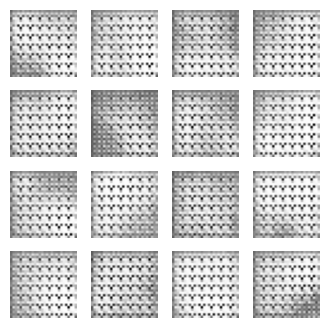

In [ ]:
def clear_output_javascript():
  """Clears the output of the current cell."""
  display(Javascript('''
    google.colab.output.clear();
  '''))


# Train the model
epochs = 25
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

for epoch in range(epochs):
    start = time.time()
    for i in range(len(train_generator)):
        images = next(train_generator)
        train_step(images)

    # Print training progress
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the final epoch
clear_output_javascript() #Call clear_output_javascript function
generate_and_save_images(generator,
                         epochs,
                         seed)

# 4. Generate New Images

# Generation

# After training, the generator can be used to generate new images by feeding it random noise.

In [ ]:
# Generate a batch of random noise
noise = tf.random.normal([batch_size, 100])  # Adjust noise dimension if needed

# Use the generator to create images
generated_images = generator(noise, training=False)

# 5. Display Real vs. Generated Images

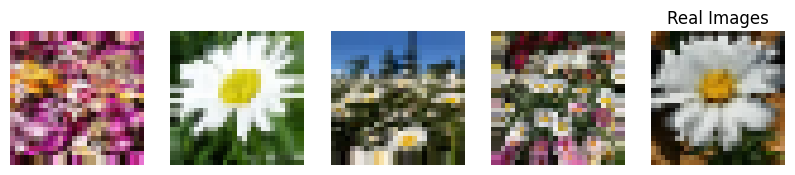

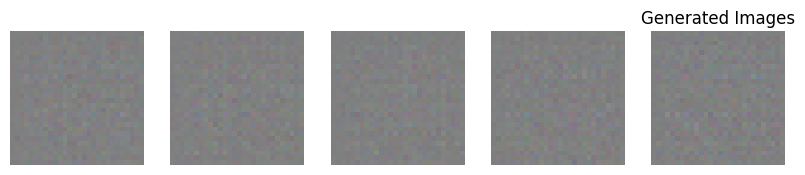

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of real images from the training generator
real_images = next(train_generator)[0]  # Assuming your generator yields (images, labels)

# Display real images
plt.figure(figsize=(10, 5))
for i in range(5):  # Display 5 real images
    plt.subplot(1, 5, i + 1)
    plt.imshow(real_images[i])
    plt.axis('off')
plt.title('Real Images')
plt.show()

# Display generated images
plt.figure(figsize=(10, 5))
for i in range(5):  # Display 5 generated images
    plt.subplot(1, 5, i + 1)
    plt.imshow(generated_images[i] * 0.5 + 0.5)  # Scale to [0, 1] if needed
    plt.axis('off')
plt.title('Generated Images')
plt.show()